In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist['data'], mnist['target']
print('X shape:',X.shape)
print('y shape:',y.shape)

#There are 70,000 images and each image has 784 features. This is because each image is
#28 x 28 pixels and each feature simply represents one pixel's intensity from 0 to 255

X shape: (70000, 784)
y shape: (70000,)


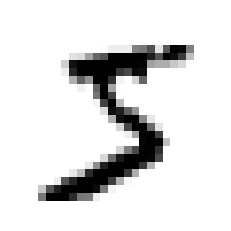

It is the number  5


In [3]:
#Lets take a peek at one digit from the dataset
import matplotlib as mpl
import matplotlib.pyplot as plt

random_number = 0
some_digit = X[random_number]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()
print('It is the number ', y[random_number])

In [4]:
import numpy as np
y = y.astype(np.uint8)

In [5]:
#Split Train-Test Datasets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit- for example, the number 5.

In [6]:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf =  SGDClassifier(random_state =42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf =  clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Let's use the 'cross_val_score()' function to evaluate our 'SGDClassifier' model, using K-fold cross-validation with three folds. Remember that K-fold-cross-validation means splitting the training set into K folds (in this case, three) then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y= None):
        return self
    
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

## Even all saying none of them has 5 has accuracy more than %90.

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images: 53892 of them were correctly classified as non-5s(true negative) while the remaining 687 were wrongly classified as non-5s (false positives). While the remaining 3530 were correctly classified as 5s (true positive), 1891 were wrongly classified as non-5s (false negatives)

* 53892 true negative
* 687 false positive
* 1891 false negative
* 3530 true positive

In [15]:
#Pretend we reach perfection
confusion_matrix(y_train_5,y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called 'precision' of the classifier

precision = TP /(TP + FP)

TP is the number of true positives, and FP is the number of false positives.

recall = TP / (TP + FN)

FN is the number of false negatives.

In [16]:
from sklearn.metrics import precision_score, recall_score

print('precision score: ',precision_score(y_train_5,y_train_pred))
print('recall score: ', recall_score(y_train_5,y_train_pred))

precision score:  0.8370879772350012
recall score:  0.6511713705958311


This means when it claims an image represents a 5, it is correct only 83% of the time. Moreover, it only detects 65% of the 5s.

It is often convenient to combine precision and recall into a single metric called the 'F1-Score' in particular if you need a simple way to compare two classifiers. The F1 score is the 'harmonic mean' of precision and recall. Whereas the regular mean treats all values equally, the **harmonic mean gives much more weight to low values.**

As a result, the classifier will only get a high F1 score if both recall and precision are high

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (**low recall**) but keeps only safe ones (**high precision**) rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier's video selection).

On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately you can't have it both ways: increasing precision reduces recall, and vice versa. This is called the **precision/recall trade-off**

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')

In [19]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

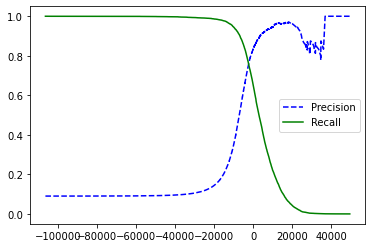

In [20]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label ='Precision')
    plt.plot(thresholds, recalls[:-1],'g-', label = 'Recall')
    plt.legend()

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

You may wonder why the precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when you raise the threshold. On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

Another way to select a good precision/recall trade-off is to plot precision directly against recall

### The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to precision versus recall, the ROC curve plots the 'true positive rate (another name for recall)' against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 the true negative rate (TNR) which is the ratio of negative instances that are correctly classified as negative. The TNR is also called 'specificity'. Hence, the ROC curve plots sensitivity (recall) versus specificity.


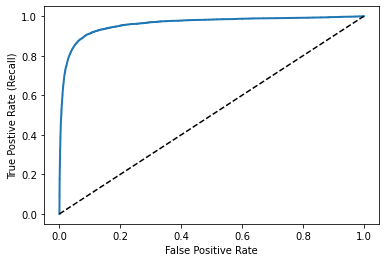

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr,tpr, label = None):
    plt.plot(fpr,tpr, linewidth=2, label = label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Postive Rate (Recall)')

plot_roc_curve(fpr,tpr)
plt.show()

Once again there is a trade-off: The higher the recall (TPR) the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner)

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5, cv=3, method='predict_proba')

In [23]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5,y_scores_forest)

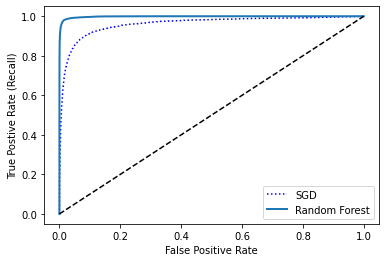

In [24]:
plt.plot(fpr,tpr,'b:', label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

As can be seen the Random Forest Classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC.

## Multiclass Classification
Two ways:

1) one-versus-the-rest (OvR) also known as one-versus-all. To classify the digit images into 10 classes train 10 binary classifiers, one for each digit. Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.

2) Another strategy is to train a binary classifier for every pair of digits. One to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s (N x (N - 1) / 2) classifiers. This strategy called one-versus-one (OvO) strategy. For the MNIST problem, this means training 45 binary classifiers.

Some algorithms (such as Support Vector Machines) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however OvR is preferred.

In [25]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train) #y_train, not y_train_5
svm_clf.predict([some_digit])


AttributeError: 'SVC' object has no attribute 'predit'

Under the hood, Scikit-learn actually used the OvO strategy: it trained 45 binary classifiers, got theirt decision scores for the image, and selected the class that won the most duels.

If you call the decision_function() method, you will see that it returns 10 scores per instance (instead of just 1). That's one score per class:

In [26]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The highest score is indeed the one corressponding to class 5:

In [31]:
print('class: ',np.argmax(some_digit_scores))
print('all classes: ',svm_clf.classes_)
print('the class of fifth: ',svm_clf.classes_[5])

print('Its lucky that fifth class is 5')

class:  5
all classes:  [0 1 2 3 4 5 6 7 8 9]
the class of fifth:  5
Its lucky that fifth class is 5


## Error Analysis

We are assuming we have done data exploration, gridsearchCV automation etc and then we want to find ways to improve our model. First look at the confusion matrix. 

In [33]:
#First lets use standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv= 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

In [34]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx =  confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

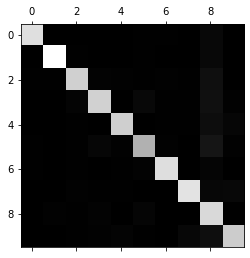

In [35]:
#That's a lot of number, It's often more convenient to look at an image representation of the confusion matrix with matshow()
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

The confusion matrix looks good, since most images are on the main diagonal, which means that they were classified correctly.

Let's focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors. (which would make abundant classes look unfairly bad):

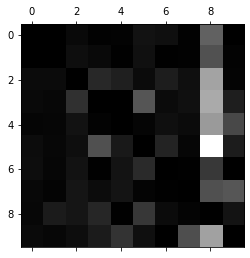

In [37]:
row_sums =conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

#Fill the diagonal with zeros to keep only the errors, and plot the results: (Gereksiz beyaz olmasınlar)

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

You can clearly see the kinds of errors the classifer makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused.

For improving the model:
1) Get more data for images which looks like at but not.

2) Engineer new features that would help the classifier (For example writing an algorithm to count the number of closed loops 8 has two, 6 has one etc.)

3) Analyzing individual errors:

In [39]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

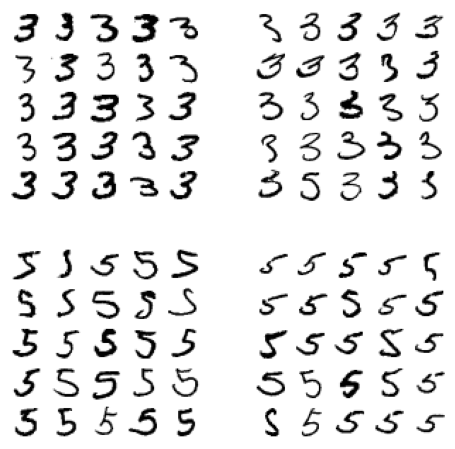

In [40]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row =5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row =5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row =5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row =5)
plt.show()

The two 5x5 blocks on the left show digits classified as 3s, and the two 5x5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong are so badly written that even a human would have trouble classifying them.

##  Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. Consider a face recognition classifier: what should it do if it recognizes several people in the same picture ? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1,0,1] (meaning Alice yes, Bob no, Charlie yes) Such a classification system that outputs multiple binary tags called a multilabel classification system

In [41]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [46]:
print('Is it larger than 7, is it odd ?')
knn_clf.predict([some_digit])

Is it larger than 7, is it odd ?


array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label ( or any other binary classifier metric discussed earlier) then simply compute the average score. This code computes the average F1 score across all labels:

In [47]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

If the classes are not equally weighted change the average='weighted' in the preceding code.

## Multioutput Classification

The last type of classificationt task is multioutput-multiclass classification or simply multioutput classification. It is simply a generalization of multilabel classification where each label can be multiclass (it can have more than two possible values)

To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

In [49]:
noise =  np.random.randint(0,100, (len(X_train), knn784))
X_train_mod = X_train + noise

noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf = KNeighborsClassifier(n_jobs = -1)
knn_clf.fit(X_train_mod, y_train_mod)

In [73]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

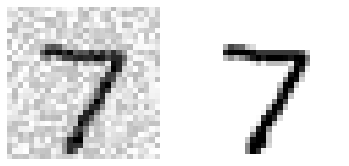

In [76]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

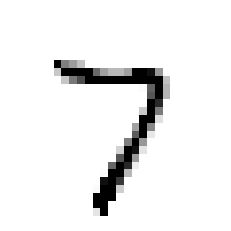

In [77]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)